This one heavily inspired by https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/files

In [72]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import Imputer,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier


In [73]:
# taken from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
#updated for ints

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() if X[c].dtype == np.dtype('float64') else X[c].median() 
                               for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [74]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [75]:
keysToUse = set(train.keys())

keysToUse.remove('ID')
keysToUse.remove('target')
keysToUse = list(keysToUse)

nonNumericKeys = list(train.select_dtypes(include=['object']).keys())

In [76]:
bigX = train[keysToUse].append(test[keysToUse])

imput = False

if imput:
    bigXimputed = DataFrameImputer().fit_transform(bigX)
    le = LabelEncoder()
    for col in nonNumericKeys:
        bigXimputed[col] = le.fit_transform(bigXimputed[col])
    trainX = bigXimputed[:train.shape[0]].as_matrix()
    testX = bigXimputed[train.shape[0]:].as_matrix()
else:
    for col in bigX:
        if col in nonNumericKeys:
            bigX[col], tmp_indexer = pd.factorize(bigX[col])
        else:
            bigX.loc[bigX[col].isnull(), col] = -9999 #train_series.mean()
    trainX = bigX[:train.shape[0]].as_matrix()
    testX = bigX[train.shape[0]:].as_matrix()

In [77]:
trainY = train['target']

In [78]:
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=700, learning_rate=0.04,nthread=4,subsample=0.9,
                        colsample_bytree=0.9)
gbm.fit(trainX, trainY)

predictionsGbm = gbm.predict_proba(testX)[:,1]
print predictions

[ 0.29482785  0.90736604  0.88187772 ...,  0.87648571  0.93920881
  0.48620355]


In [79]:
ext = ExtraTreesClassifier(n_estimators=700,max_features=70,n_jobs=4,criterion= 'entropy', min_samples_split= 4,
                            max_depth=20, min_samples_leaf=2)

ext.fit(trainX,trainY)

predictionsExt = ext.predict_proba(testX)[:,1]

In [35]:
output = pd.DataFrame({'ID': test['ID'],'PredictedProb': predictions})
output.to_csv('submission.csv',index=False)

In [80]:
print predictionsGbm
print predictionsExt

[ 0.07822778  0.90490222  0.68608886 ...,  0.93501407  0.96718204
  0.55719835]
[ 0.33704203  0.79291506  0.86980619 ...,  0.90172146  0.94633912
  0.56963426]


In [81]:
print predictionsGbm-predictionsExt

[-0.25881425  0.11198716 -0.18371733 ...,  0.03329261  0.02084292
 -0.01243591]


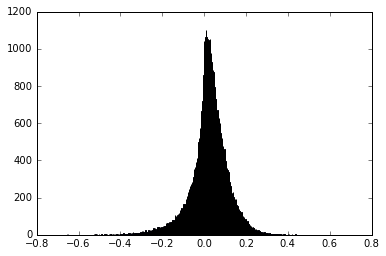

In [84]:
import matplotlib.pyplot as plt

%matplotlib inline

x,y,z = plt.hist(predictionsGbm-predictionsExt,bins=1000)

In [85]:
output = pd.DataFrame({'ID': test['ID'],'PredictedProb': 0.5*(predictionsGbm+predictionsExt)})
output.to_csv('submission_avg.csv',index=False)

In [ ]:
(predictionsGbm-)